# PLAYGROUND

In [5]:
%reload_ext autoreload
%autoreload 2

import os
from matplotlib import pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sns
os.environ['KERAS_BACKEND'] = 'torch'
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

import keras
from src.EEGModalNet.data.dataloader import LEMONEEGDataModule
from src.EEGModalNet.models.gan import SimpleGAN
from src.EEGModalNet.data.mock_temporal_data import MockTemporalData
from src.EEGModalNet.utils import ProgressBarCallback
from tqdm.auto import tqdm

# helper functions
def train_model(model, x, max_epochs, early_stopping=True, logger_dir='tmp/keras_logs/simple_gan_v1.csv', patience=100):
    reusable_pbar=tqdm(total=max_epochs, unit='epoch', leave=False, dynamic_ncols=True)
    
    model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=True),
                d_optimizer=keras.optimizers.Adam(0.001),
                g_optimizer=keras.optimizers.Adam(0.0001))
    
    callbacks = [keras.callbacks.CSVLogger(logger_dir),
                 ProgressBarCallback(n_epochs=max_epochs, n_runs=1, run_index=0, reusable_pbar=reusable_pbar)]
    if early_stopping:
        callbacks.append(keras.callbacks.EarlyStopping(monitor='d_loss', mode='min', patience=patience))

    history = model.fit(
        x,
        epochs=max_epochs,
        verbose=0, # type: ignore
        shuffle=True,
        callbacks=callbacks
    )
    return history

def plot_history(history):
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['d_loss'], label='discriminator')
    plt.plot(history.history['g_loss'], label='generator')
    plt.legend()
    plt.show()

def plot_losses(history, loss='g_loss', s=30):
    loss = history.history[loss]
    loss = pd.Series(loss).rolling(s).mean()
    plt.plot(loss)
    # add the mean of g_loss to the plot as a text
    mean = loss.mean()
    plt.text(len(loss)-90, mean, f'mean={mean:.3f}', fontsize=12)

## GAN

In [ ]:
# parameters
n_features = 10
latent_dim = 64

# data
data = MockTemporalData(n_samples=20, n_features=n_features, n_timepoints=100)
x, _ = data()

# model
model = SimpleGAN(time_dim=100, feature_dim=n_features, latent_dim=latent_dim)
history = train_model(model, x, max_epochs=10000, early_stopping=True)

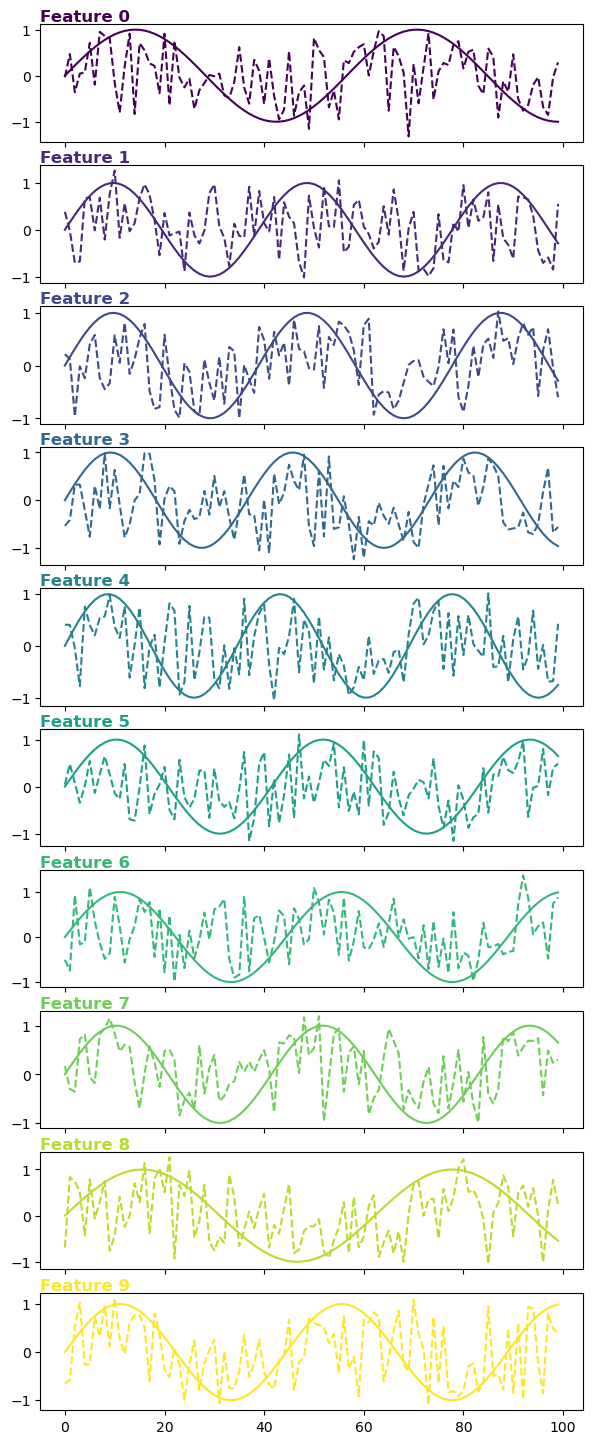

In [40]:
from matplotlib import pyplot as plt
import numpy as np
subject_to_plot = 0
feature_to_plot = range(n_features)
noise = keras.random.normal((1, latent_dim))
x_gen = model.generator(noise)
# pick colors based on the number of features
colors = plt.cm.viridis(np.linspace(0, 1, n_features))
# share x axis

fig, axes = plt.subplots(n_features, 1, figsize=(7, 1.8*n_features), sharex=True)
for i, (c, f) in enumerate(zip(colors, feature_to_plot)):
    axes[i].plot(x[subject_to_plot, :, f], label='real', color=c)
    axes[i].plot(x_gen[subject_to_plot, :, f].cpu().detach().numpy().squeeze(), label='generated', color=c, linestyle='--')
    axes[i].set_title(f'Feature {f}', fontsize=12, fontweight='bold', color=c, loc='left', verticalalignment='top')
plt.show()

## Load model from checkpoints

In [ ]:
from src.EEGModalNet.models import SimpleGAN
model = SimpleGAN(time_dim=100, feature_dim=1, latent_dim=64)
model.load_weights('tmp/keras_models/simple_gan_v1_HPC.model.keras')

## Train with Real Data

### Timeseries

In [ ]:
data = LEMONEEGDataModule(n_subjects=1).prepare_data()
x = data.train_dataset['x'].mean(axis=2)[20:40]
x = x[np.newaxis, 19, :, np.newaxis].repeat(20, axis=0)

model = SimpleGAN(time_dim=128, feature_dim=1, latent_dim=100)
history = train_model(model, x, max_epochs=1000, early_stopping=True, patience=200)

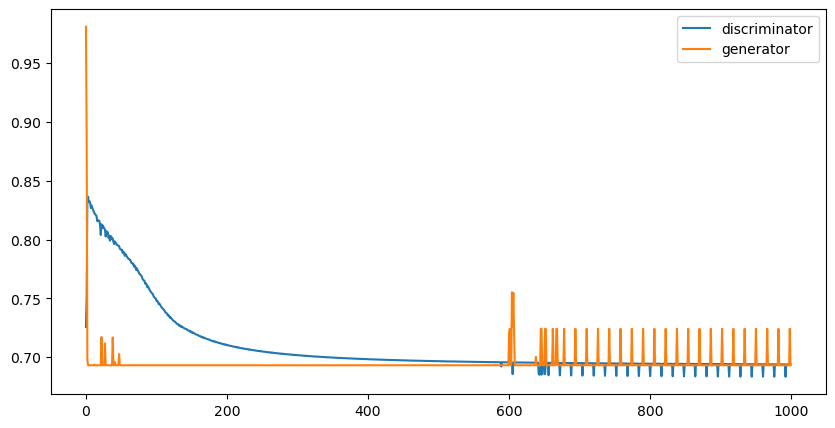

In [14]:
plot_history(history)

In [23]:
from keras import layers
input_layer = keras.Input(shape=(100,))
x = layers.Reshape((1, 100))(input_layer)
x = layers.Conv1D(128, 3, padding='same')(x)
x = layers.LeakyReLU(negative_slope=0.2)(x)
x = layers.Conv1D(256, 3, padding='same')(x)
x = layers.LeakyReLU(negative_slope=0.2)(x)
x = layers.Conv1D(512, 3, padding='same')(x)
x = layers.LeakyReLU(negative_slope=0.2)(x)
x = layers.Dense(128 * 1)(x)
x = layers.Reshape((128, 1))(x)

# Residual connections
x = layers.Add()([x, input_layer])

generator = keras.Model(inputs=input_layer, outputs=x, name='generator')

generator.summary()

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16      │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_19          │ (None, 1, 100)    │          0 │ input_layer_16[0… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_28 (Conv1D)  │ (None, 1, 128)    │     38,528 │ reshape_19[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_28      │ (None, 1, 128)    │          0 │ conv1d_28[0][0]   │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_29 (Conv1D)  │ (None, 1, 256)    │     98,560 │ leaky_re_lu_28[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_29      │ (None, 1, 256)    │          0 │ conv1d_29[0][0]   │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_30 (Conv1D)  │ (None, 1, 512)    │    393,728 │ leaky_re_lu_29[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_30      │ (None, 1, 512)    │          0 │ conv1d_30[0][0]   │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_27 (Dense)    │ (None, 1, 128)    │     65,664 │ leaky_re_lu_30[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_20          │ (None, 128, 1)    │          0 │ dense_27[0][0]    │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 128, 100)  │          0 │ reshape_20[0][0], │
│                     │                   │            │ input_layer_16[0… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 596,480 (2.28 MB)

 Trainable params: 596,480 (2.28 MB)

 Non-trainable params: 0 (0.00 B)

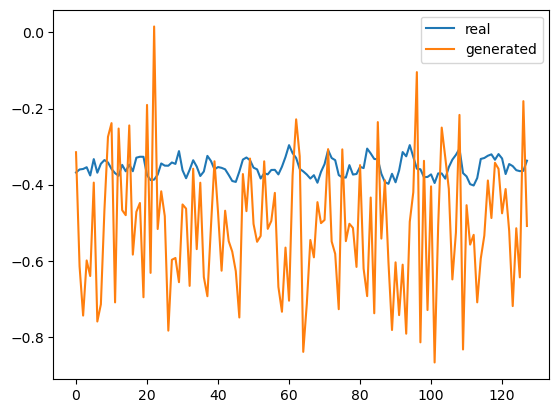

x_gen: tensor([[2.2815e-08]], device='mps:0', grad_fn=<SigmoidBackward0>) 
x: tensor([[2.4916e-06],
        [1.7067e-06],
        [4.6856e-06],
        [3.0696e-06],
        [3.0497e-06],
        [3.9594e-06],
        [4.0675e-06],
        [4.0047e-06],
        [2.3811e-06],
        [2.7084e-06],
        [5.1155e-06],
        [3.3875e-06],
        [3.2467e-06],
        [1.7339e-06],
        [1.4052e-06],
        [2.3473e-06],
        [3.5508e-06],
        [2.2990e-06],
        [3.0505e-06],
        [2.6173e-06]], device='mps:0', grad_fn=<SigmoidBackward0>)


In [61]:
x_gen = model.generator(keras.random.normal((1, 64)))
b_to_plot = 10
plt.plot(x[b_to_plot, :], label='real')
plt.plot(x_gen.cpu().detach().numpy().squeeze(), label='generated')
plt.legend()
plt.show()
print('x_gen:', model.discriminator(x_gen), '\nx:', model.discriminator(x))

It seems that the discriminator does not learn to tell the generated from the real models apart. Also the generated data is similar to noise, and we cannot tell if it has ever learned anything unless we check if they show similar properties such as their mean, variance, power spectrum, etc. Then we switch to using a simpler data, for example the wavelets instead of raw data in the next section.
The second solution might be making the generator more complex, for example by adding more layers, or using a different architecture therefore it could learn the nauances of the data better.

### Wavelets

In [ ]:
# data
wavelets = xr.open_dataarray('data/LEMON_data/wavelets.nc5')
x = wavelets.sel(subject=wavelets.subject[0]).to_numpy()
# x = np.moveaxis(x, 0, -1)
x = x[np.newaxis, :, 0:2]

# model
model = SimpleGAN(time_dim=61, feature_dim=2, latent_dim=64)
history = train_model(model, x, max_epochs=10000, early_stopping=True)

In [88]:
x_gen = model.generator(keras.random.normal((1, 64)))
model.discriminator(x_gen), model.discriminator(x)

(tensor([[1.]], device='mps:0', grad_fn=<SigmoidBackward0>),
 tensor([[8.9189e-10]], device='mps:0', grad_fn=<SigmoidBackward0>))

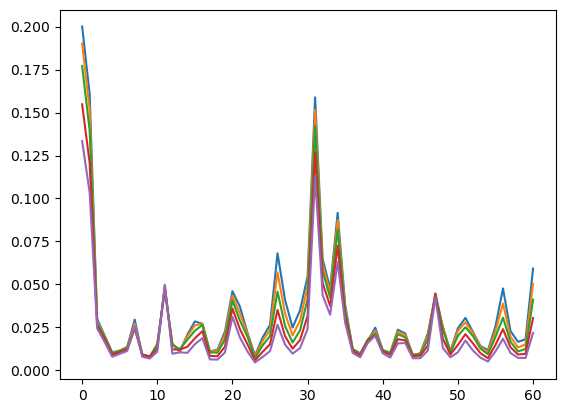

In [11]:
for i in range(5, 10):
    plt.plot(x[:, i], label='real')
plt.show()

*Observation 1*: The discriminator works really fine in telling the generated from real data apart. However, the generator does not produce realistics data (it might make the job easy for the discriminator).

*Observation 2*: From the amplitude of the wavelets, plotted across 61 channels we can see that there is definetly a problem with these values. They are completely out of range, so maybe the mere normaliation might help. Also the EEG data might need some steps to be preprocessed, such as filtering, or removing the artifacts.

**Next Steps:**

- As the first step, I made my data much simpler: instead of having 61 channels or so I only included the power spectrum from 2 channels.

- or a timeseries data, but all the samples would be the same.

- Second step would be extracting time-frequency data, instead of only having the power of each frequency bin. In this case, I'd like to see if the model can generate the sinusoidal waves with different frequencies and amplitudes.

- Next step would be changing the architecture of the generator and discriminator, for example adding more layers, and leveraging the power of the convolutional neural networks, batch normalizations and residual connections for the generator.

- In the end, I'd train a convolusional GAN which impose a more complex task to the discriminator to solve.

## WGAN

In [3]:
from src.EEGModalNet.models.WGAN import WGAN_GP
import torch

In [78]:
path = 'data/LEMON_data/eeg_EC_BaseCorr_Norm_Clamp_with_pos.nc5'
data = xr.open_dataarray(path, engine='h5netcdf')
x = data.sel(subject=data.subject[19]).to_numpy()
x = x[np.newaxis, 27, 3000:5400]
# unfold the time dimension
x = torch.tensor(x).unfold(1, 600, 600).permute(1, 2, 0)

# Instantiate and compile the model
wgan_gp = WGAN_GP(time_dim=600, feature_dim=1, latent_dim=200)

generator_optimizer = keras.optimizers.Adam(0.0001, beta_1=0.5, beta_2=0.9)
discriminator_optimizer = keras.optimizers.Adam(0.0004, beta_1=0.5, beta_2=0.9)

wgan_gp.compile(
                d_optimizer=discriminator_optimizer,
                g_optimizer=generator_optimizer,
                gradient_penalty_weight=1.0)

history = wgan_gp.fit(x, epochs=1500)

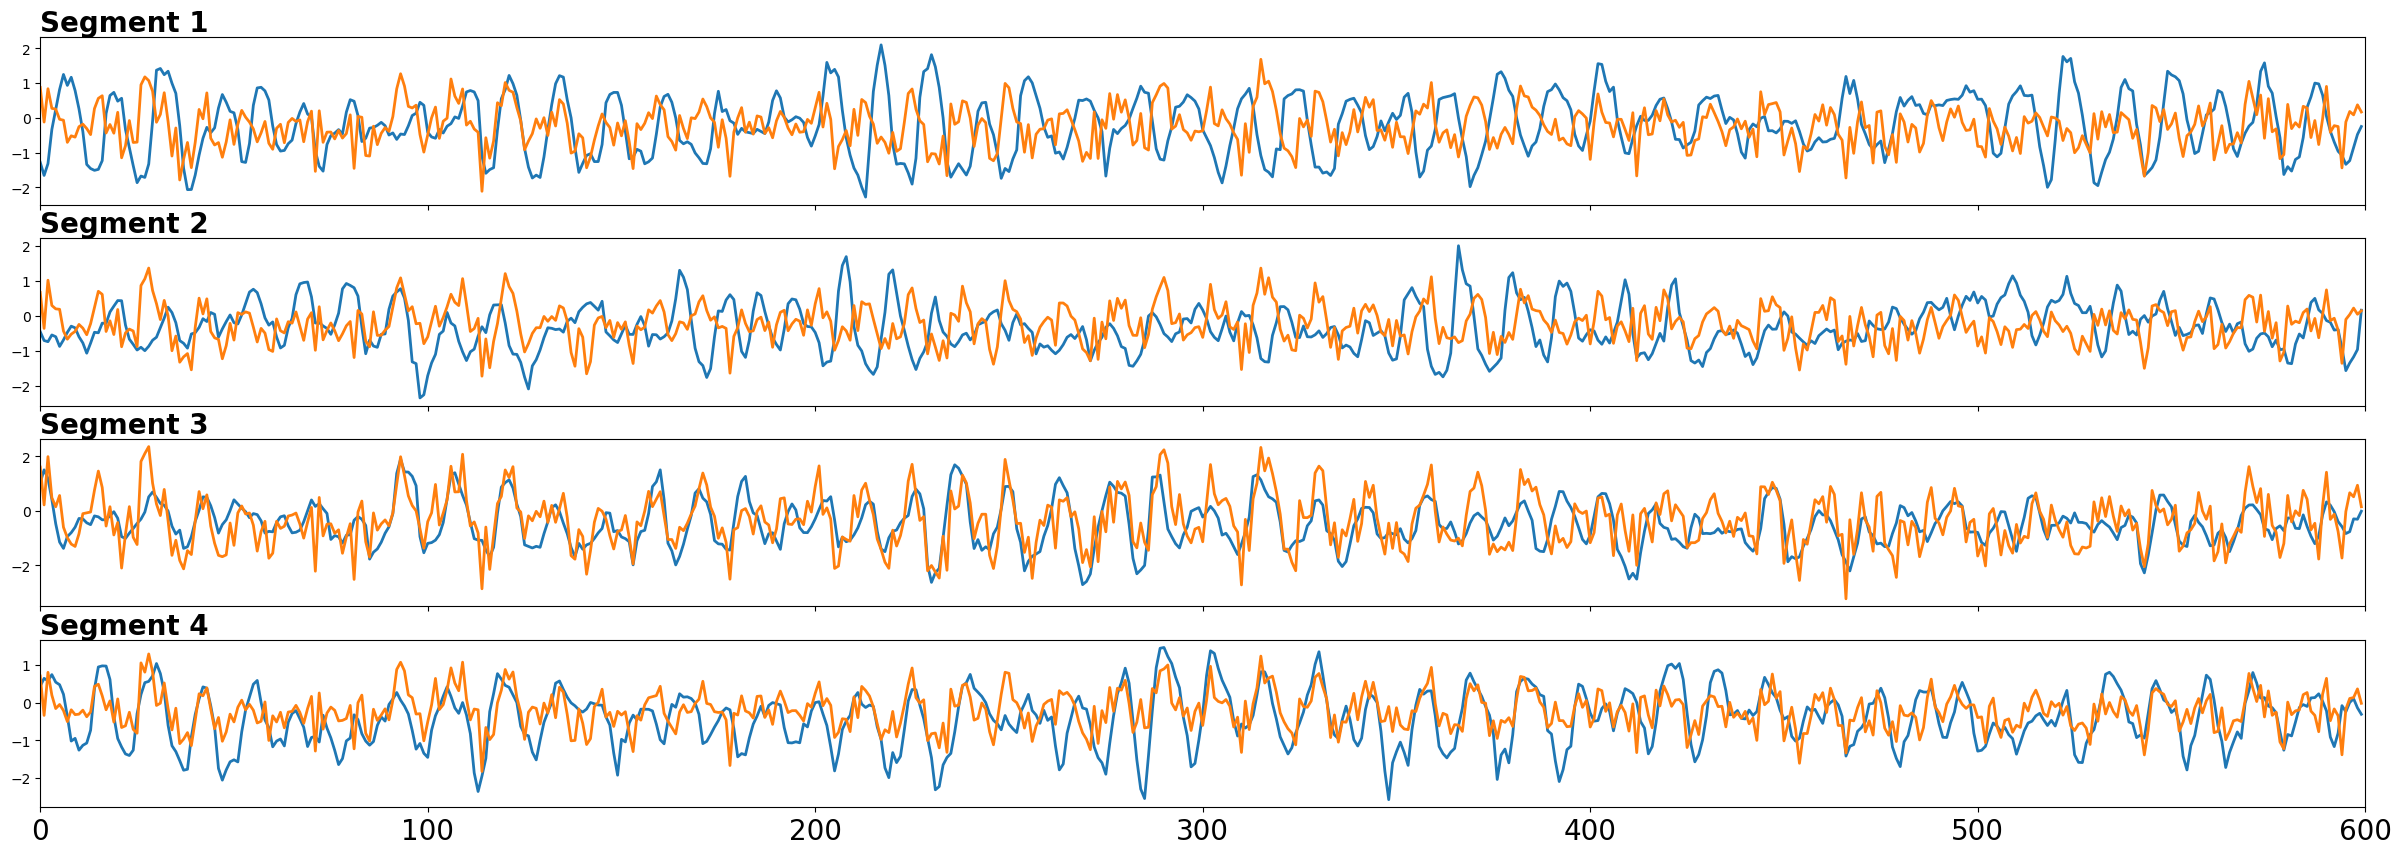

In [82]:
noise = torch.zeros(20, 200)
means = x.mean(dim=1).mean(dim=1)
stds = x.std(dim=1).mean(dim=1)
for i in range(x.shape[0]):
    noise[i] = keras.random.normal((200,), mean=means[i], stddev=stds[i])

x_gen = wgan_gp.generator(noise).cpu().detach().numpy()
n_seg = 4
fig, axes = plt.subplots(n_seg, 1, figsize=(30, 10), sharex=True)
for i in range(n_seg):
    axes[i].plot(x[i, :, 0], label='real', linewidth=2)
    axes[i].plot(x_gen[i, :, 0], label='generated', linewidth=2)
    axes[i].set_title(f'Segment {i+1}', fontsize=20, fontweight='bold', loc='left', verticalalignment='top')
plt.xticks(fontsize=20)
plt.xlim(0, 600)
plt.show()

In [83]:
wgan_gp.discriminator(x_gen), wgan_gp.discriminator(x)

(tensor([[0.1147],
         [0.1469],
         [0.9064],
         [0.8806]], device='mps:0', grad_fn=<SigmoidBackward0>),
 tensor([[0.9918],
         [0.9511],
         [0.9999],
         [0.9897]], device='mps:0', grad_fn=<SigmoidBackward0>))

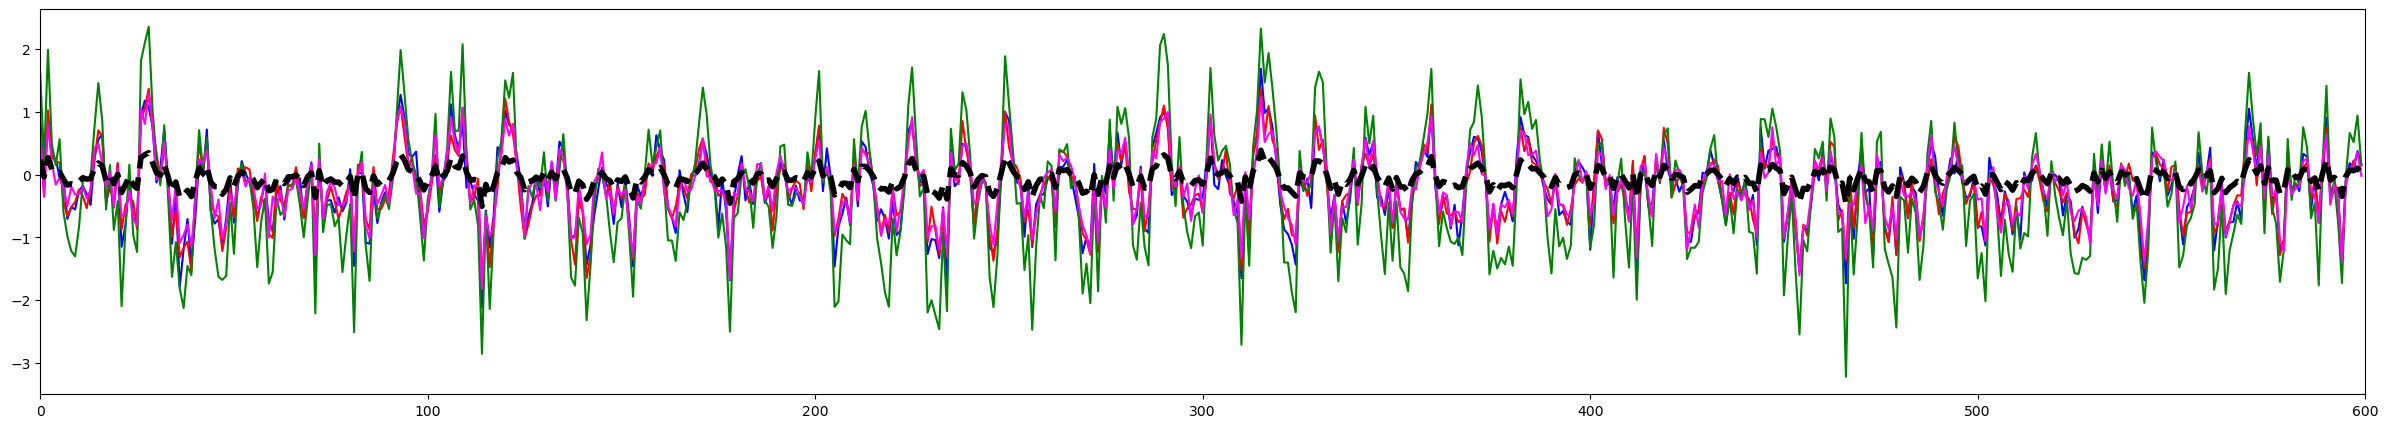

In [95]:
# plot overlap of the generated data
plt.figure(figsize=(30, 5))
colors = ['blue', 'red', 'green', 'magenta']
for i, c in enumerate(colors):
    plt.plot(x_gen[i, :, 0], color=c)
plt.plot(x_gen.mean(axis=0), color='black', linewidth=4, linestyle='--', label='mean')
plt.xlim(0, 600)
plt.show()

(0.0, 600.0)

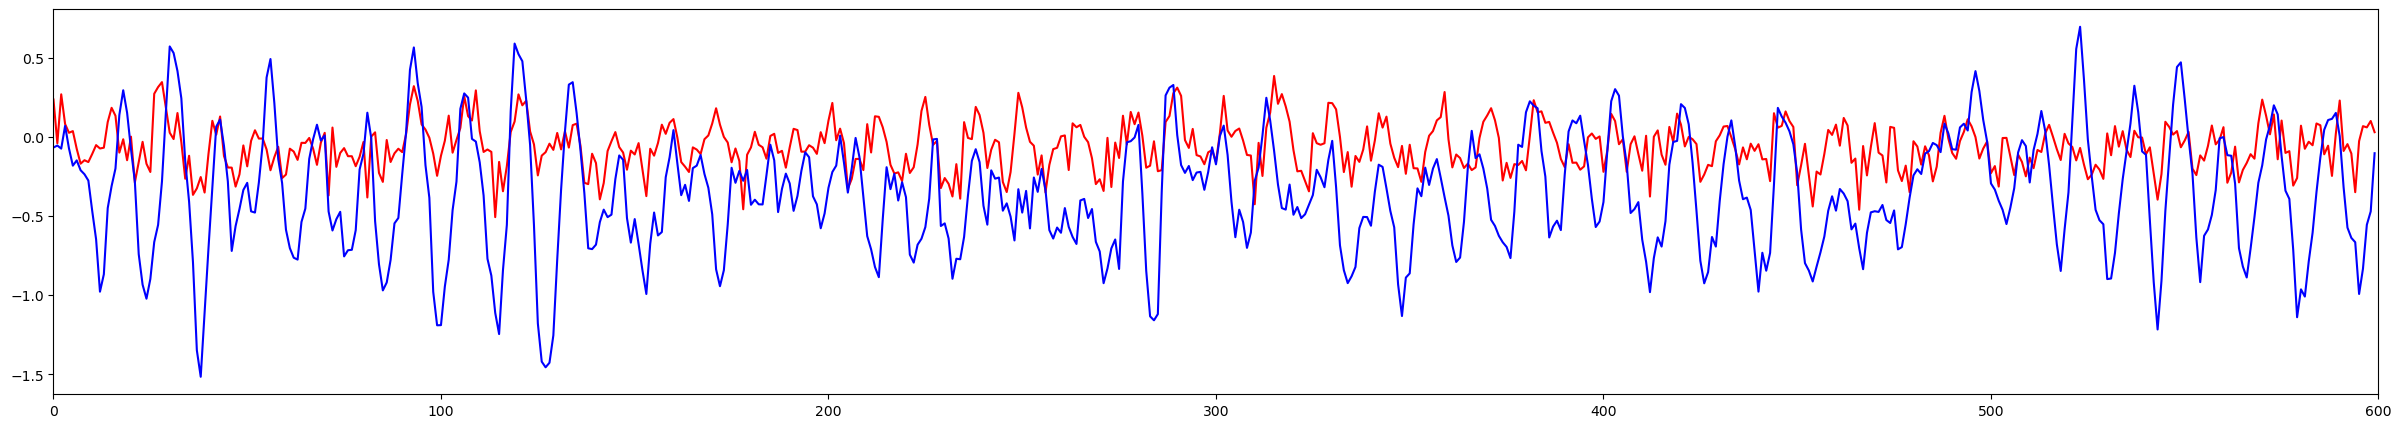

In [98]:
# plot the mean/std fake vs. real in a single graph to see if their distributions are the same
plt.figure(figsize=(30, 5))
plt.plot(x_gen.mean(axis=0), label='fake', color='red')
plt.plot(x.mean(axis=0), label='real', color='blue')
plt.xlim(0, 600)

**Observations:**

1. Decreasing landa (the wieght of the gradient penalty) from 10 to 1, imporved the performance of the generator when the mock data was used. However, the discriminator could not tell real from generated data apart. it could be due to the fact that the generator has become too powerful, and the discriminator could not learn to tell the difference.

2. When using the real data, especially data with 300 timepoints from O1 and O2 channels from only one subject, that would exhibit sinusoidal alpha waves during the eyes closed state, generator did a great job in generating the data that looks like the real data, while discriminator could also tell the difference. However, when I used data from Fp1 and Fp2 channels, which are more complicated, the loss of discriminator converged to 1 after 500 epochs, and the generator loss also converged to a negative value relatively fast and stayed the same. This might be due to the fact that the generator could not learn the nauances of the data, and the discriminator could not tell the difference.

3. I retrained the data with O1 and O2 and was able to replicate the good performance of the generator but not the discriminator. If the discriminator could not classify real from fake data how can we expect it to understand the underlying structure of different classes later when using conditional GANs? This is an important point. Maybe we need to freeze the generator after training and focus on the discriminator.

4. I retrained the data increasing the wieght of the gradient penalty and guess what generator can now produce more realistic data, but not completely matching. the discriminator still do a tribble job and intrestingly it always output probbality of 0.4746 for both real or fake x, which is equal to the absolute value of the generator's loss the point it converged and stayed fast. The discriminator also converged to point 4 and stayed there. 

5. there are two ways of calculating gradients: using the adam optimizer in keras or pytorch optimizers and the corresponding codes. I tried both for my best performing model so far and the result was the same.

6. The effect of batch normalizations within the generator: it does not impact neither the performance of discriminator nor the generator

7. latent dim should be a function of the number of timepoints or the complexity of the signal, the longer the signal segments and the higher the power of the higher frequencies such as gamma the bigger the value of the latent dim.
Similarly, the complexity of the network would be a function of the complexity of signal, to produce more complext data we need a network with higher capacity and greater number of layers stacked on each others

9. when we used four differnt samples of the data without repeating them, the model that was trained for 1500 steps always showed a matching-with-real data generation for one of the segments (segment 2 in above graph).

-- what would be the impact of changing the arch of the generator or discriminator?

## Visualize 2d manifold using tSNE

In [ ]:
import torch
from sklearn.manifold import TSNE
from src.EEGModalNet.models.WGAN import WGAN_GP

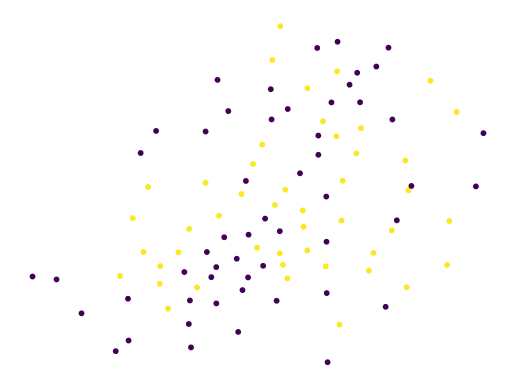

In [76]:
x = data.sel(subject=data.subject[:100]).to_numpy()
x = x.mean(axis=-1)
y_data = data.gender[:100]

np.random.seed(None)
tsne = TSNE(perplexity=30, n_components=2, n_iter=300, random_state=None, verbose=0)
X_data_2D = tsne.fit_transform(x)
X_data_2D = (X_data_2D - X_data_2D.min()) / (X_data_2D.max() - X_data_2D.min())
plt.scatter(X_data_2D[:, 0], X_data_2D[:, 1], c=y_data, s=10)
plt.axis('off')
plt.show()